## Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Loading and Plotting

In [2]:
#training_set = pd.read_csv('nikkei_stock_average_daily_jp.csv', encoding="shift-jis")
training_set = pd.read_csv('currency_data.csv')

training_set.describe()

,Jul.Day,CAD/USD,EUR/USD,GBP/USD,JPY/USD,AUD/USD,CNY/USD
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.458484e+06,1.315726,0.876246,0.772500,109.585010,1.384095,6.796261
std,4.219961e+02,0.038004,0.034728,0.027389,2.755661,0.084416,0.222525
min,2.457757e+06,1.212800,0.800860,0.698140,102.240000,1.234100,6.269900
25%,2.458122e+06,1.294700,0.849403,0.758018,107.560000,1.318375,6.651875
50%,2.458486e+06,1.317800,0.879425,0.771805,109.620000,1.383550,6.858350
75%,2.458851e+06,1.335150,0.900413,0.790590,111.652500,1.437825,6.945175
max,2.459215e+06,1.449600,0.960130,0.865480,117.670000,1.725300,7.177500


In [3]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Jul.Day     1000 non-null   int64  
 1   YYYY/MM/DD  1000 non-null   object 
 2   Wdy         1000 non-null   object 
 3   CAD/USD     1000 non-null   float64
 4   EUR/USD     1000 non-null   float64
 5   GBP/USD     1000 non-null   float64
 6   JPY/USD     1000 non-null   float64
 7   AUD/USD     1000 non-null   float64
 8   CNY/USD     1000 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 70.4+ KB


In [4]:
training_set.head()

,Jul.Day,YYYY/MM/DD,Wdy,CAD/USD,EUR/USD,GBP/USD,JPY/USD,AUD/USD,CNY/USD
0,2457757,2017/01/03,Tue,1.3438,0.96013,0.81596,117.67,1.3831,6.9627
1,2457758,2017/01/04,Wed,1.3293,0.95461,0.81328,117.43,1.3755,6.9343
2,2457759,2017/01/05,Thu,1.3216,0.94353,0.80566,115.42,1.3637,6.8905
3,2457760,2017/01/06,Fri,1.3216,0.94704,0.81214,116.85,1.3692,6.9194
4,2457763,2017/01/09,Mon,1.3222,0.94558,0.82201,116.08,1.3582,6.9370


[[  1.3438    0.96013   0.81596 117.67      1.3831    6.9627 ]
 [  1.3293    0.95461   0.81328 117.43      1.3755    6.9343 ]
 [  1.3216    0.94353   0.80566 115.42      1.3637    6.8905 ]
 ...
 [  1.2806    0.81629   0.74092 103.61      1.3137    6.5303 ]
 [  1.2769    0.81378   0.73499 103.23      1.3026    6.5248 ]
 [  1.2732    0.81573   0.73252 103.09      1.2946    6.5326 ]]


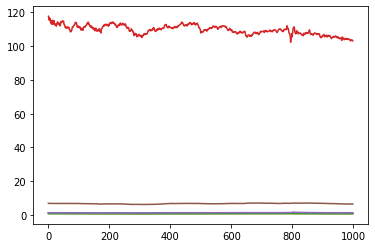

In [5]:
training_set = training_set.iloc[:,3:9].values
print(training_set)
plt.plot(training_set, label = 'Data')
plt.show()

## Dataloading

In [6]:
def scaling_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length][3]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 10
x, y = scaling_window(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)).view(-1,1))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).view(-1, 1))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])).view(-1, 1))

## Model

In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.fc1 = nn.Linear(input_size, num_classes)
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        x_1 = self.fc1(x)
        ula, (h_out, _) = self.lstm(x_1, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc2(h_out)
        
        return out

## Training

In [10]:
# Parameter setting 
num_epochs = 3000
p_interval = num_epochs / 20
learning_rate = 0.01

input_size = 6
hidden_size = 16
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if (epoch + 1) % p_interval == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch+1, loss.item()))

Epoch: 150, loss: 0.00137
Epoch: 300, loss: 0.00095
Epoch: 450, loss: 0.00084
Epoch: 600, loss: 0.00082
Epoch: 750, loss: 0.00082
Epoch: 900, loss: 0.00082
Epoch: 1050, loss: 0.00082
Epoch: 1200, loss: 0.00082
Epoch: 1350, loss: 0.00082
Epoch: 1500, loss: 0.00082
Epoch: 1650, loss: 0.00082
Epoch: 1800, loss: 0.00081
Epoch: 1950, loss: 0.00081
Epoch: 2100, loss: 0.00081
Epoch: 2250, loss: 0.00080
Epoch: 2400, loss: 0.00080
Epoch: 2550, loss: 0.00080
Epoch: 2700, loss: 0.00079
Epoch: 2850, loss: 0.00079
Epoch: 3000, loss: 0.00079


## Testing for Currency (6 pairs)  Dataset

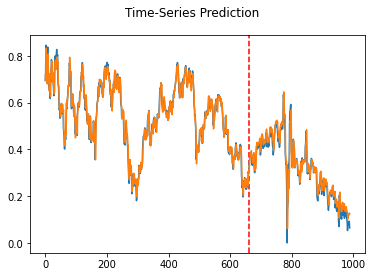

In [11]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()